# Triplet Loss

In [1]:
# Create output directories if nor exist
from pathlib import Path

MODEL_DIR = "models"
FIG_DIR = "figures"

Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

With Contrastive Loss, our model was struggling to push apart embeddings far enough to allow for reliable differentiation of hard pairings.

Triplet Loss aims to fix this. Instead of comparing the reference (anchor) image to a single positive or negative sample, the anchor image is always compared against a positive **and** negative sample.

Let's use TensorFlow's `TripletSemiHardLoss` to explore triplet loss.

For implementations of Triplet Loss the Siamese Network Architecture is usually interpreted a bit more loosely:
Instead of defining a model with multiple inputs, shared weights and a distance layer, a model with a single input is used and the distances are computed and compared for the model outputs within a whole batch.

In [2]:
from core.dataset import DGSAlphabet

TEST_LABELS = ['u', 'v', 'w', 'x', 'y']

# Import the dataset
dataset = DGSAlphabet()
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)
x_train = categorical_dataset.x_train
y_train = categorical_dataset.y_train
x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

We'll instantiate our encoder as always, but append a L2 Normalization layer since it is required for the TFA implementation of Triplet Loss.

To give the model the best shot at success we'll use Keras Tuner once again.

In [3]:
from tensorflow_addons.losses import TripletSemiHardLoss
from core.util import new_SNN_builder

# Create model builder for Keras Tuner
build_model = new_SNN_builder(
    mode="encoder_l2",
    loss=TripletSemiHardLoss(
        margin=1.0,
        distance_metric="angular"
    )
)

/Users/moritz/Documents/Hochschule Augsburg/Semester 2 - Master/Data Science/project/venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Tuning Hyperparameters
# https://keras.io/api/keras_tuner/tuners/hyperband
MAX_EPOCHS = 200
FACTOR = 3
HYPERBAND_ITERATIONS = 1
SEED = 42
VAL_SPLIT = 0.2

# Where to save tuner checkpoints
TUNER_DIR = "tuner"
PROJECT = "triplet_loss"

In [5]:
import keras_tuner

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=MAX_EPOCHS,
    factor=FACTOR,
    hyperband_iterations=HYPERBAND_ITERATIONS,
    seed=SEED,
    directory=TUNER_DIR,
    project_name=PROJECT
)

tuner.search_space_summary()

Search space summary
Default search space size: 7
dense_count (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': 'linear'}
dense_base (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
encoder_dropout (Boolean)
{'default': False, 'conditions': []}
start_lr (Float)
{'default': 5e-05, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.001, 'step': 5e-05, 'sampling': 'linear'}
beta_1 (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
beta_2 (Float)
{'default': 0.99, 'conditions': [], 'min_value': 0.99, 'max_value': 0.999, 'step': 0.001, 'sampling': 'linear'}
epsilon (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.001, 'sampling': 'linear'}


We'll use the same callbacks as for the Contrastive Loss training.

In [6]:
from core.util import new_default_callbacks

from core.util import new_default_callbacks, TunerHistoryCallback

# Reduce learning rate if no improvement is made
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_loss",
    mode="min",
    lr_reduce_factor=0.2,
    lr_reduce_patience=10,
    early_stopping_start=10,
    early_stopping_patience=20,
    verbose=1
)

# Keep track of histories for every tuner trial
tuner_history_cb = TunerHistoryCallback(tuner)

In [7]:
tuner.search(
    x_train, 
    y_train,
    validation_split=VAL_SPLIT,
    callbacks=[reduce_lr, early_stop, tuner_history_cb]
)

Trial 252 Complete [00h 00m 32s]
val_loss: 0.8241050243377686

Best val_loss So Far: 0.10158593952655792
Total elapsed time: 03h 36m 03s


In [8]:
tuner.results_summary()

Results summary
Results in tuner/triplet_loss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0246 summary
Hyperparameters:
dense_count: 4
dense_base: 48
encoder_dropout: False
start_lr: 0.0007000000000000001
beta_1: 0.7
beta_2: 0.998
epsilon: 0.001
tuner/epochs: 200
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.10158593952655792

Trial 0233 summary
Hyperparameters:
dense_count: 6
dense_base: 64
encoder_dropout: False
start_lr: 0.0007000000000000001
beta_1: 0.7999999999999999
beta_2: 0.992
epsilon: 0.008
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0226
Score: 0.13295254111289978

Trial 0232 summary
Hyperparameters:
dense_count: 10
dense_base: 40
encoder_dropout: False
start_lr: 0.0004
beta_1: 0.7
beta_2: 0.998
epsilon: 0.010000000000000002
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0229
Score: 0.14004473388195038

Trial 0206 summary
Hyperparameters:
d

Since we want convenient access to the model's encoder part, we'll re-instantiate the model with the best architecture and transfer the best model's weights:

In [9]:
# Get history of best model training
best_trial = tuner.oracle.get_best_trials(1)[0]
best_model_history = tuner_history_cb.get_trial_history(
    best_trial.trial_id
)

# Get weights of best model
best_model = tuner.get_best_models(1)[0]
best_weights = best_model.weights

# Re-create best architecture
best_hyper_params = tuner.get_best_hyperparameters(1)[0]
snn_encoder, siamese_snn = build_model(best_hyper_params, get_encoder=True)
siamese_snn.set_weights(best_weights)

siamese_snn.summary()

Model: "encoder_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Landmark_Input (InputLayer  [(None, 21, 3)]           0         
 )                                                               
                                                                 
 Layer_Norm (LayerNormaliza  (None, 21, 3)             6         
 tion)                                                           
                                                                 
 Flatten_Landmarks (Flatten  (None, 63)                0         
 )                                                               
                                                                 
 Dense_1 (Dense)             (None, 768)               49152     
                                                                 
 Dense_2 (Dense)             (None, 432)               332208    
                                                        

Let's save the best model and take a look at its training history:

In [10]:
from pathlib import Path

MODEL_DIR = "models"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

siamese_snn.save(f"{MODEL_DIR}/triplet_loss.keras")

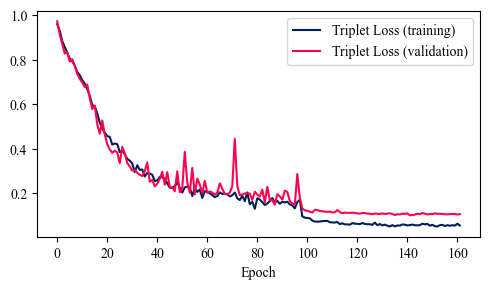

In [11]:
from core.viz import visualize_history

visualize_history(
    best_model_history,
    ["loss"],
    "Triplet Loss",
    f"{FIG_DIR}/triplet_loss_history.svg"
)

Our accuracy on new signs however, seems significantly worse than with Contrastive Loss (at least in absolute loss numbers):

In [12]:
# And evaluate the model on test data
loss = siamese_snn.evaluate(x_test, y_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.8102


Evaluating the model on One-Shot classification unfortunately shows the same trend:

In [13]:
from core.util import evaluate_n_way_accuracy


y_true, y_pred, mean_acc, min_acc, max_acc, std = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=1,
    iterations=10
)

print(
    f"Mean 5-way accuracy: {mean_acc}\n"
    f"Min 5-way accuracy: {min_acc}\n"
    f"Max 5-way accuracy: {max_acc}\n"
    f"5-way accuracy std.: {std}"
)

50/50 [==============================] - 0s 699us/step
Mean 5-way accuracy: 0.6079746835443038
Min 5-way accuracy: 0.4936708860759494
Max 5-way accuracy: 0.6810126582278481
5-way accuracy std.: 0.06357795770277734


In [14]:
k_prototype = [1, 3, 5, 10, 15, 20, 50, 75, 100]

for k in k_prototype:
    _, _, n_way_acc_pk, _, _, std = evaluate_n_way_accuracy(
        x_test,
        y_test,
        snn_encoder,
        k_prototype=k,
        iterations=10
    )

    print(
        f"Mean 5-way accuracy (k-prototype = {k}): {n_way_acc_pk}, std: {std}"
    )

50/50 [==============================] - 0s 711us/step
Mean 5-way accuracy (k-prototype = 1): 0.6079746835443038, std: 0.06357795770277734
50/50 [==============================] - 0s 701us/step
Mean 5-way accuracy (k-prototype = 3): 0.6540127388535031, std: 0.06878202362172792
50/50 [==============================] - 0s 697us/step
Mean 5-way accuracy (k-prototype = 5): 0.7123076923076923, std: 0.034026085441419746
50/50 [==============================] - 0s 681us/step
Mean 5-way accuracy (k-prototype = 10): 0.7336807817589577, std: 0.021970533124513386
50/50 [==============================] - 0s 687us/step
Mean 5-way accuracy (k-prototype = 15): 0.730728476821192, std: 0.0103158317767527
50/50 [==============================] - 0s 699us/step
Mean 5-way accuracy (k-prototype = 20): 0.7296969696969697, std: 0.009870317392902506
50/50 [==============================] - 0s 760us/step
Mean 5-way accuracy (k-prototype = 50): 0.7295880149812735, std: 0.015340268014270589
50/50 [==============

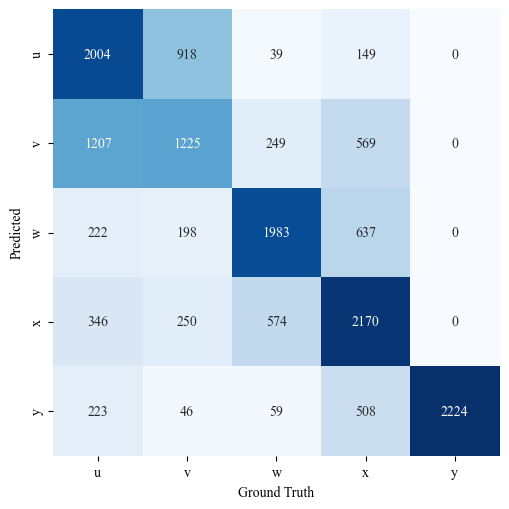

In [15]:
from core.viz import visualize_confusion_matrix

unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(
    y_true, y_pred,
    str_test_labels,
    f"{FIG_DIR}/triplet_loss_conf_matrix.svg"
)

In [16]:
# Get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

50/50 [==============================] - 0s 859us/step


In [17]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1585 samples in 0.000s...
[t-SNE] Computed neighbors for 1585 samples in 0.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1585
[t-SNE] Computed conditional probabilities for sample 1585 / 1585
[t-SNE] Mean sigma: 0.001232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.130238
[t-SNE] KL divergence after 1000 iterations: 0.283937


Again, the confusion matrix is reflected in the model's embeddings:

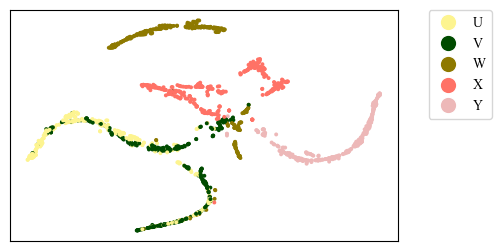

In [18]:
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
visualize_embeddings(
    reduced_embeddings,
    y_test,
    label_map,
    f"{FIG_DIR}/triplet_loss_embeddings.svg"
)